In [ ]:
!pip install ultralytics --no-deps
!pip install --upgrade nvidia-cuda-nvcc-cu12==12.5.40


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 4.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82


In [ ]:
root_dir = "/content"
runtime_dir = !pwd
if runtime_dir[0] != root_dir:
    raise Exception("Runtime folder does not match root folder.")
!rm -rf *
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import torch
import logging

orig_torch_load = torch.load

def torch_wrapper(*args, **kwargs):
    kwargs['weights_only'] = False
    return orig_torch_load(*args, **kwargs)

torch.load = torch_wrapper

NODE_CLASS_MAPPINGS = {}
__all__ = ['NODE_CLASS_MAPPINGS']

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
from keras import layers, models, optimizers
from keras.preprocessing import image_dataset_from_directory
from ultralytics import settings
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
settings.update({"wandb": False})

In [ ]:
!curl -u leprieto:fnnXN-KRkr9-dWJqy-x2GEE-E3P5N -o 00_pseudo_model.zip "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/jupyter/02_pseudo_model.zip"
!unzip -q 00_pseudo_model.zip -d 00_pseudo_model
!rm 00_pseudo_model.zip

!curl -u leprieto:fnnXN-KRkr9-dWJqy-x2GEE-E3P5N -o 01_dataset.zip "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/00_clean_filtered_dataset/dataset.zip"
!unzip -q 01_dataset.zip -d 01_dataset
!rm 01_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.9M  100 27.9M    0     0  5170k      0  0:00:05  0:00:05 --:--:-- 7154k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  13.1M      0  0:00:15  0:00:15 --:--:-- 15.6M


In [ ]:
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras import Model, layers
from ultralytics import YOLO

def _torch_conv_weights(conv: torch.nn.Conv2d):
    w = conv.weight.detach().cpu().numpy()
    w = np.transpose(w, (2, 3, 1, 0))  # (H, W, in_c/groups, out_c)
    return [w] + ([conv.bias.detach().cpu().numpy()] if conv.bias is not None else [])

def _torch_bn_weights(bn: torch.nn.BatchNorm2d):
    return [
        bn.weight.detach().cpu().numpy(),
        bn.bias.detach().cpu().numpy(),
        bn.running_mean.detach().cpu().numpy(),
        bn.running_var.detach().cpu().numpy(),
    ]

def conv_bn_silu(x, tblock, name, *, log=False):
    tconv: torch.nn.Conv2d = tblock.conv
    tbn: torch.nn.BatchNorm2d = tblock.bn

    pad_h, pad_w = tconv.padding
    if pad_h or pad_w:
        x = layers.ZeroPadding2D(padding=(pad_h, pad_w), name=f"{name}_pad")(x)
        keras_padding = "valid"
    else:
        keras_padding = "valid"

    conv = layers.Conv2D(
        filters=tconv.out_channels,
        kernel_size=tconv.kernel_size,
        strides=tconv.stride,
        padding=keras_padding,
        dilation_rate=tconv.dilation,
        groups=tconv.groups,
        use_bias=tconv.bias is not None,
        name=f"{name}_conv",
    )
    x = conv(x)

    bn = layers.BatchNormalization(
        epsilon=tbn.eps,
        momentum=1 - tbn.momentum,
        name=f"{name}_bn",
    )
    x = bn(x)

    x = layers.Activation("swish", name=f"{name}_silu")(x)

    conv.set_weights(_torch_conv_weights(tconv))
    bn.set_weights(_torch_bn_weights(tbn))

    if log:
        k = conv.kernel.shape
        print(f"{name:20s} | g={tconv.groups:<2d} bias={tconv.bias is not None} | stride={tconv.stride}  pad=({pad_h})  W→{k}")

    return x

def convert_c2f(x, tblock, idx, *, log=False):
    x = conv_bn_silu(x, tblock.cv1, f"c2f{idx}_cv1", log=log)

    half = x.shape[-1] // 2
    x1 = layers.Lambda(lambda z: z[..., :half], name=f"c2f{idx}_split1")(x)
    x2 = layers.Lambda(lambda z: z[..., half:], name=f"c2f{idx}_split2")(x)

    parts = [x1, x2]
    for j, bottleneck in enumerate(tblock.m):
        identity = x2
        x2 = conv_bn_silu(x2, bottleneck.cv1, f"c2f{idx}_b{j}cv1", log=log)
        x2 = conv_bn_silu(x2, bottleneck.cv2, f"c2f{idx}_b{j}cv2", log=log)
        if bottleneck.add:
            x2 = layers.Add(name=f"c2f{idx}_b{j}_add")([identity, x2])
        parts.append(x2)

    x = layers.Concatenate(name=f"c2f{idx}_concat")(parts)
    x = conv_bn_silu(x, tblock.cv2, f"c2f{idx}_cv2", log=log)

    x = layers.Lambda(lambda z: z, name=f"stage{idx}_out")(x)
    return x

def convert_sppf(x, tblock, idx, *, log=False):
    x = conv_bn_silu(x, tblock.cv1, f"sppf{idx}_cv1", log=log)

    p1 = layers.MaxPooling2D(5, 1, "same", name=f"sppf{idx}_p1")(x)
    p2 = layers.MaxPooling2D(5, 1, "same", name=f"sppf{idx}_p2")(p1)
    p3 = layers.MaxPooling2D(5, 1, "same", name=f"sppf{idx}_p3")(p2)
    x = layers.Concatenate(name=f"sppf{idx}_concat")([x, p1, p2, p3])

    x = conv_bn_silu(x, tblock.cv2, f"sppf{idx}_cv2", log=log)
    x = layers.Lambda(lambda z: z, name=f"stage{idx}_out")(x)
    return x

def build_keras_backbone(t_backbone, input_shape=(320, 320, 3), *, verbose=False):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for idx, layer in enumerate(t_backbone.children()):
        lname = layer._get_name()
        if lname == "Conv":
            x = conv_bn_silu(x, layer, f"conv{idx}", log=verbose)
            x = layers.Lambda(lambda z: z, name=f"stage{idx}_out")(x)
        elif lname == "C2f":
            x = convert_c2f(x, layer, idx, log=verbose)
        elif lname == "SPPF":
            x = convert_sppf(x, layer, idx, log=verbose)
        else:
            raise ValueError(f"Unsupported layer type: {lname}")

    return Model(inputs, x, name="keras_yolov8_backbone")

def _make_k_debug(model, n_stages):
    outs = [model.get_layer(f"stage{i}_out").output for i in range(n_stages)]
    return Model(model.input, outs)

# ---------------------------------------------------------------------------
# ── Checkers ───────────────────────────────────────────────────────────────-
# ---------------------------------------------------------------------------

def compare_backbones(t_backbone, k_backbone, shape=(320, 320, 3), n=5, seed=0, *, verbose=False):
    if verbose:
        return compare_backbones_layerwise(t_backbone, k_backbone, shape, n, seed)
    mx_abs = mx_rel = 0.0
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    for _ in range(n):
        x_np = rng.standard_normal((1, *shape), dtype=np.float32)
        with torch.no_grad():
            y_t = t_backbone(torch.from_numpy(x_np).permute(0, 3, 1, 2)).cpu().numpy()
            y_t = np.transpose(y_t, (0, 2, 3, 1))
        y_k = k_backbone(x_np, training=False).numpy()
        d = np.abs(y_k - y_t)
        r = d / (np.abs(y_t) + 1e-8)
        mx_abs = max(mx_abs, d.max())
        mx_rel = max(mx_rel, r.max())
    print(f"overall max |Δ| = {mx_abs:.3e}\tmax relΔ = {mx_rel:.3e}")
    return mx_abs, mx_rel


def compare_backbones_layerwise(t_backbone, k_backbone, shape=(320, 320, 3), n=1, seed=0):
    k_debug = _make_k_debug(k_backbone, len(list(t_backbone.children())))
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    x_np = rng.standard_normal((1, *shape), dtype=np.float32)
    with torch.no_grad():
        x_t = torch.from_numpy(x_np).permute(0, 3, 1, 2)
        t_outs = []
        for m in t_backbone.children():
            x_t = m(x_t)
            t_outs.append(x_t.cpu().numpy().transpose(0, 2, 3, 1))

    k_outs = k_debug(x_np, training=False)

    for idx, (t_o, k_o) in enumerate(zip(t_outs, k_outs)):
        d = np.abs(k_o - t_o)
        print(f"stage {idx:<2d} | max |Δ| {d.max():.3e}  mean |Δ| {d.mean():.3e}")

    return None

yolo = YOLO("/content/00_pseudo_model/weights/best.pt")
t_backbone = torch.nn.Sequential(*list(yolo.model.model.children())[:10]).eval()

k_backbone = build_keras_backbone(t_backbone, verbose=True)
k_backbone.save("yolov8_backbone.keras", overwrite=True)

compare_backbones(t_backbone, k_backbone, n=1, verbose=True)

k_backbone.summary()


conv0                | g=1  bias=False | stride=(2, 2)  pad=(1)  W→(3, 3, 3, 16)
conv1                | g=1  bias=False | stride=(2, 2)  pad=(1)  W→(3, 3, 16, 32)
c2f2_cv1             | g=1  bias=False | stride=(1, 1)  pad=(0)  W→(1, 1, 32, 32)
c2f2_b0cv1           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 16, 16)
c2f2_b0cv2           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 16, 16)
c2f2_cv2             | g=1  bias=False | stride=(1, 1)  pad=(0)  W→(1, 1, 48, 32)
conv3                | g=1  bias=False | stride=(2, 2)  pad=(1)  W→(3, 3, 32, 64)
c2f4_cv1             | g=1  bias=False | stride=(1, 1)  pad=(0)  W→(1, 1, 64, 64)
c2f4_b0cv1           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 32, 32)
c2f4_b0cv2           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 32, 32)
c2f4_b1cv1           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 32, 32)
c2f4_b1cv2           | g=1  bias=False | stride=(1, 1)  pad=(1)  W→(3, 3, 32, 32)
c2f4_cv2         

Model: "keras_yolov8_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,277,680 (4.87 MB)

 Trainable params: 1,272,656 (4.85 MB)

 Non-trainable params: 5,024 (19.62 KB)

In [ ]:
def resize_and_pad(image, label):
    TARGET_SIZE = 320
    PADDING_COLOR = 114

    image = tf.cast(image, tf.float32)

    shape = tf.shape(image)
    h = shape[0]
    w = shape[1]

    scale = tf.minimum(TARGET_SIZE / tf.cast(h, tf.float32),
                       TARGET_SIZE / tf.cast(w, tf.float32))

    new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * scale), tf.int32)
    new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * scale), tf.int32)

    resized = tf.image.resize(image, [new_h, new_w], method="bilinear")

    pad_h = TARGET_SIZE - new_h
    pad_w = TARGET_SIZE - new_w
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded = tf.pad(resized,
                    paddings=[[pad_top, pad_bottom],
                              [pad_left, pad_right],
                              [0, 0]],
                    constant_values=PADDING_COLOR)

    padded.set_shape([TARGET_SIZE, TARGET_SIZE, 3])
    padded = padded / 255.0
    return padded, tf.reshape(label, [1])

In [ ]:
def set_trainable_layers(model, start: int, end: int):
    """Enable training for specified layer range in the model."""
    for layer in model.layers[start:end]:
        layer.trainable = True

def compile_model(model, learning_rate: float = 1e-5):
    """Compile the model with Adam optimizer and binary crossentropy loss."""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

def get_callbacks(filepath: str):
    """Create ModelCheckpoint callback to save best model weights."""
    return [
        tf.keras.callbacks.ModelCheckpoint(
            filepath,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        )
    ]

def train_model(model, train_dataset, val_dataset, class_weights, epochs, callbacks):
    """Train the model and return the training history."""
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks
    )
    return history

def evaluate_model(model, val_dataset, weight_file):
    """Load best weights and evaluate the model."""
    model.load_weights(weight_file)
    loss, accuracy = model.evaluate(val_dataset)
    print(f"\nValidation Accuracy: {accuracy*100:.2f}%")
    return loss, accuracy

def print_loss_curves(history):
    """Print training and validation loss curves."""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    print(f"Loss: {train_loss}")
    print(f"Validation Loss: {val_loss}")

def evaluate_performance(model, test_dataset, weight_file):
  true_labels = []
  predictions = []
  for images, labels in test_dataset:
      true_labels.extend(labels.numpy())
      batch_pred = model.predict(images)
      predictions.extend((batch_pred > 0.5).astype(int).flatten())

  true_labels = np.array(true_labels)
  predictions = np.array(predictions)

  cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
  cm_display = ConfusionMatrixDisplay(cm, display_labels=['def', 'ok'])
  report = classification_report(true_labels, predictions, target_names=['def', 'ok'])
  cm_display.plot(cmap=plt.cm.Blues)
  plt.savefig(f"confusion_matrix_{weight_file}.svg")
  plt.show()
  print(report)


Found 6569 files belonging to 2 classes.
Using 5256 files for training.
Using 1313 files for validation.
Found 715 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 229,697 (897.25 KB)

 Non-trainable params: 1,277,680 (4.87 MB)

Epoch 1/100
    165/Unknown 23s 71ms/step - accuracy: 0.5245 - loss: 0.7010

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.5246 - loss: 0.7010 - val_accuracy: 0.5209 - val_loss: 0.6972
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.6035 - loss: 0.6597 - val_accuracy: 0.6040 - val_loss: 0.6440
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.6332 - loss: 0.6101 - val_accuracy: 0.7113 - val_loss: 0.5342
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.7040 - loss: 0.5479 - val_accuracy: 0.6976 - val_loss: 0.5472
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.6963 - loss: 0.5430 - val_accuracy: 0.7304 - val_loss: 0.5221
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.7419 - loss: 0.4936 - val_accuracy: 0.7570 - val_loss: 0.4665
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7644 - loss: 0.4582 - val_accuracy: 0.7799 - val_loss: 0.4349
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7647 - loss: 0.4414 -

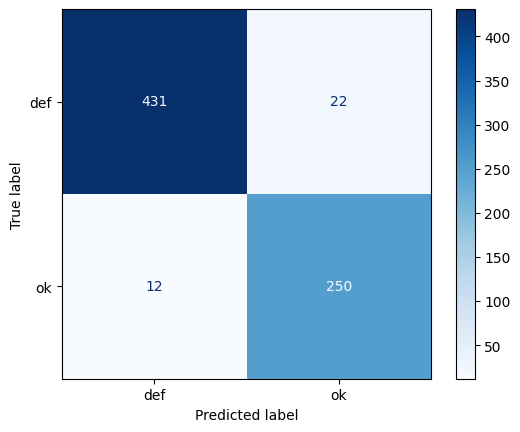

              precision    recall  f1-score   support

         def       0.97      0.95      0.96       453
          ok       0.92      0.95      0.94       262

    accuracy                           0.95       715
   macro avg       0.95      0.95      0.95       715
weighted avg       0.95      0.95      0.95       715



In [ ]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 100
DATA_DIR = '01_dataset/dataset/casting_data/casting_data/train/'

train_dataset, val_dataset = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_dataset = image_dataset_from_directory(
    '01_dataset/dataset/casting_data/casting_data/test/',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=1,
    label_mode='binary'
)

train_dataset = train_dataset.unbatch().map(resize_and_pad, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.unbatch().map(resize_and_pad, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.unbatch().map(resize_and_pad, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

k_backbone.trainable = False  # Freeze all layers

x = k_backbone.get_layer("stage9_out").output

# Classification head
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=k_backbone.input, outputs=output)
compile_model(model, 1e-3)

labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels.flatten()
)
class_weights = {i: w for i, w in enumerate(class_weights)}
weight_file = "model.weights.h5"
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, EPOCHS, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

In [ ]:
# Stages composing the backbone.
i = 0
for layer in model.layers:
  if "_out" in layer.name:
    print(f"Layer: {layer.name} Index: {i}")
  i += 1

Layer: stage0_out Index: 5
Layer: stage1_out Index: 10
Layer: stage2_out Index: 29
Layer: stage3_out Index: 34
Layer: stage4_out Index: 62
Layer: stage5_out Index: 67
Layer: stage6_out Index: 95
Layer: stage7_out Index: 100
Layer: stage8_out Index: 119
Layer: stage9_out Index: 130


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 854,593 (3.26 MB)

 Non-trainable params: 652,784 (2.49 MB)

Epoch 1/30
    165/Unknown 70s 86ms/step - accuracy: 0.7741 - loss: 0.9570

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 75s 122ms/step - accuracy: 0.7744 - loss: 0.9552 - val_accuracy: 0.8591 - val_loss: 0.4539
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8661 - loss: 0.3856 - val_accuracy: 0.8819 - val_loss: 0.3640
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8887 - loss: 0.2857 - val_accuracy: 0.8941 - val_loss: 0.3022
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9028 - loss: 0.2412 - val_accuracy: 0.9025 - val_loss: 0.2778
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9121 - loss: 0.2223 - val_accuracy: 0.9040 - val_loss: 0.2637
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9117 - loss: 0.2099 - val_accuracy: 0.9132 - val_loss: 0.2442
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9241 - loss: 0.1890 - val_accuracy: 0.9109 - val_loss: 0.2304
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9268 - loss: 0.1722 - val_acc

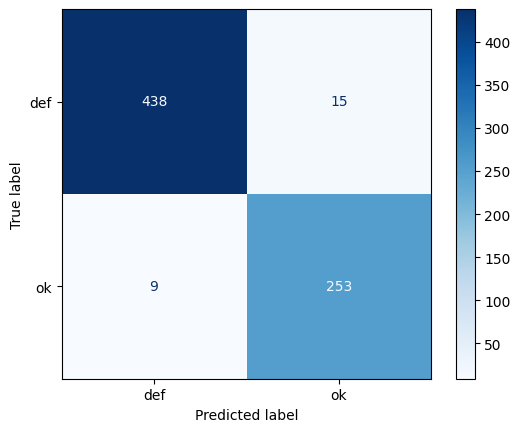

              precision    recall  f1-score   support

         def       0.98      0.97      0.97       453
          ok       0.94      0.97      0.95       262

    accuracy                           0.97       715
   macro avg       0.96      0.97      0.96       715
weighted avg       0.97      0.97      0.97       715



In [ ]:
# Fine Tuning: Stage 8-9.
weight_file = "model89.weights.h5"
set_trainable_layers(model, 101, 130)
compile_model(model)
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, 30, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 1,347,649 (5.14 MB)

 Non-trainable params: 159,728 (623.94 KB)

Epoch 1/30
    165/Unknown 36s 98ms/step - accuracy: 0.9396 - loss: 0.1814

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.9397 - loss: 0.1812 - val_accuracy: 0.9276 - val_loss: 0.1900
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9572 - loss: 0.1156 - val_accuracy: 0.9436 - val_loss: 0.1676
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9641 - loss: 0.0929 - val_accuracy: 0.9406 - val_loss: 0.1599
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9640 - loss: 0.0914 - val_accuracy: 0.9467 - val_loss: 0.1505
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9695 - loss: 0.0852 - val_accuracy: 0.9459 - val_loss: 0.1660
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9741 - loss: 0.0688 - val_accuracy: 0.9535 - val_loss: 0.1408
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.9748 - loss: 0.0720 - val_accuracy: 0.9520 - val_loss: 0.1374
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9710 - loss: 0.0735 - val_accu

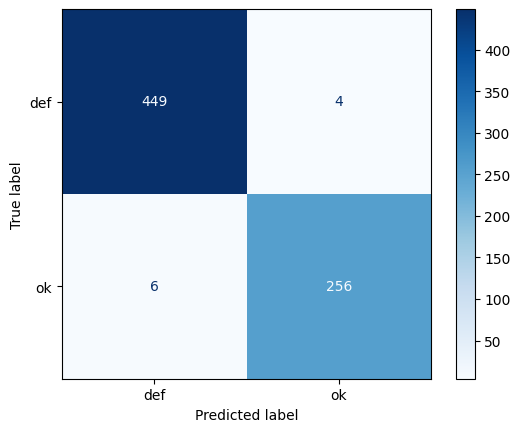

              precision    recall  f1-score   support

         def       0.99      0.99      0.99       453
          ok       0.98      0.98      0.98       262

    accuracy                           0.99       715
   macro avg       0.99      0.98      0.98       715
weighted avg       0.99      0.99      0.99       715



In [ ]:
# Fine Tuning: Stage 6-7.
weight_file = "model67.weights.h5"
set_trainable_layers(model, 68, 100)
compile_model(model)
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, 30, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 1,471,297 (5.61 MB)

 Non-trainable params: 36,080 (140.94 KB)

Epoch 1/30
    165/Unknown 43s 114ms/step - accuracy: 0.9918 - loss: 0.0311

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 63s 235ms/step - accuracy: 0.9918 - loss: 0.0311 - val_accuracy: 0.9764 - val_loss: 0.1011
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.9937 - loss: 0.0254 - val_accuracy: 0.9726 - val_loss: 0.1120
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9910 - loss: 0.0253 - val_accuracy: 0.9749 - val_loss: 0.1090
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9941 - loss: 0.0206 - val_accuracy: 0.9779 - val_loss: 0.0988
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9948 - loss: 0.0197 - val_accuracy: 0.9749 - val_loss: 0.1026
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9950 - loss: 0.0199 - val_accuracy: 0.9787 - val_loss: 0.0931
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.9966 - loss: 0.0170 - val_accuracy: 0.9802 - val_loss: 0.0954
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9971 - loss: 0.0152 - val_ac

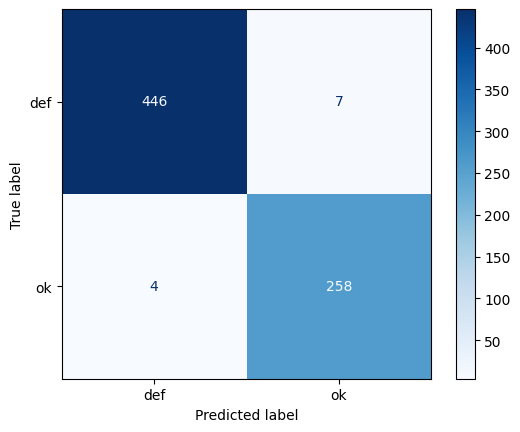

              precision    recall  f1-score   support

         def       0.99      0.98      0.99       453
          ok       0.97      0.98      0.98       262

    accuracy                           0.98       715
   macro avg       0.98      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715



In [ ]:
# Fine Tuning: Stage 4-5.
weight_file = "model45.weights.h5"
set_trainable_layers(model, 35, 67)
compile_model(model)
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, 30, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 1,497,217 (5.71 MB)

 Non-trainable params: 10,160 (39.69 KB)

Epoch 1/30
    165/Unknown 51s 136ms/step - accuracy: 0.9977 - loss: 0.0095

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step - accuracy: 0.9977 - loss: 0.0095 - val_accuracy: 0.9840 - val_loss: 0.0903
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9976 - loss: 0.0092 - val_accuracy: 0.9810 - val_loss: 0.0972
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9959 - loss: 0.0138 - val_accuracy: 0.9810 - val_loss: 0.0857
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9991 - loss: 0.0062 - val_accuracy: 0.9817 - val_loss: 0.0978
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9968 - loss: 0.0129 - val_accuracy: 0.9779 - val_loss: 0.0985
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9840 - val_loss: 0.0901
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.9986 - loss: 0.0067 - val_accuracy: 0.9825 - val_loss: 0.0936
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9991 - loss: 0.0053 - val_acc

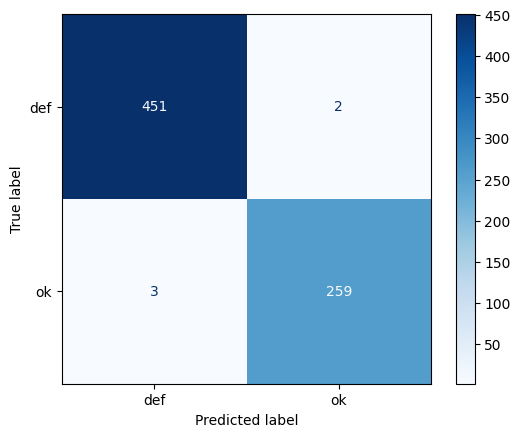

              precision    recall  f1-score   support

         def       0.99      1.00      0.99       453
          ok       0.99      0.99      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [ ]:
# Fine Tuning: Stage 2-3.
weight_file = "model23.weights.h5"
set_trainable_layers(model, 11, 34)
compile_model(model)
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, 30, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_pad           │ (None, 322, 322,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_conv (Conv2D) │ (None, 160, 160,  │        432 │ conv0_pad[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_bn            │ (None, 160, 160,  │         64 │ conv0_conv[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0_silu          │ (None, 160, 160,  │          0 │ conv0_bn[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage0_out (Lambda) │ (None, 160, 160,  │          0 │ conv0_silu[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 162, 162,  │          0 │ stage0_out[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      4,608 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        128 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_silu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_out (Lambda) │ (None, 80, 80,    │          0 │ conv1_silu[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_conv       │ (None, 80, 80,    │      1,024 │ stage1_out[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_bn         │ (None, 80, 80,    │        128 │ c2f2_cv1_conv[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_cv1_silu       │ (None, 80, 80,    │          0 │ c2f2_cv1_bn[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_split2         │ (None, 80, 80,    │          0 │ c2f2_cv1_silu[0]… │
│ (Lambda)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_pad      │ (None, 82, 82,    │          0 │ c2f2_split2[0][0] │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2f2_b0cv1_conv     │ (None, 80, 80,    │      2,304 │ c2f2_b0cv1_pad[0

 Total params: 1,507,377 (5.75 MB)

 Trainable params: 1,502,353 (5.73 MB)

 Non-trainable params: 5,024 (19.62 KB)

Epoch 1/30
    165/Unknown 56s 158ms/step - accuracy: 0.9984 - loss: 0.0053

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


165/165 ━━━━━━━━━━━━━━━━━━━━ 62s 196ms/step - accuracy: 0.9984 - loss: 0.0053 - val_accuracy: 0.9787 - val_loss: 0.0979
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9958 - loss: 0.0137 - val_accuracy: 0.9840 - val_loss: 0.0910
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9840 - val_loss: 0.1115
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.9979 - loss: 0.0048 - val_accuracy: 0.9855 - val_loss: 0.0899
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.9825 - val_loss: 0.0888
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9832 - val_loss: 0.0914
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9855 - val_loss: 0.0719
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9978 - loss: 0.0048 - val_accu

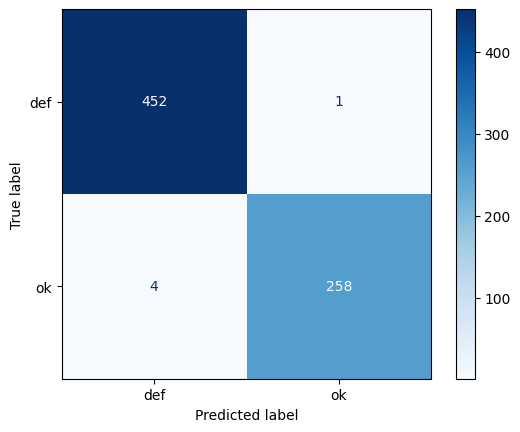

              precision    recall  f1-score   support

         def       0.99      1.00      0.99       453
          ok       1.00      0.98      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [ ]:
# Fine Tuning: Stage 0-1.
weight_file = "model01.weights.h5"
set_trainable_layers(model, 0, 10)
compile_model(model)
callbacks = get_callbacks(weight_file)
history = train_model(model, train_dataset, val_dataset, class_weights, 30, callbacks)
evaluate_model(model, val_dataset, weight_file)
print_loss_curves(history)
evaluate_performance(model, test_dataset, weight_file)

In [ ]:
!zip -r *

Streaming output truncated to the last 5000 lines.
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_71.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_6333.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_745.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_1488.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_7618.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_8649.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_cast_ok_0_6666.jpeg (deflated 2%)
  adding: 01_dataset/dataset/casting_data/casting_data/train/ok_front/casting_data_train_ca